[課題のURL](https://https://diver.diveintocode.jp/curriculums/1648)

# Sprint 機械学習スクラッチ 決定木

機械学習スクラッチ入門のSprintで用意したシンプルデータセット2の2値分類に対してスクラッチ実装の学習と推定を行なってください。

In [162]:
import math
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.animation as animation
import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

from collections import Counter

In [163]:
X = np.array([[-0.44699 , -2.8073  ],[-1.4621  , -2.4586  ],
       [ 0.10645 ,  1.9242  ],[-3.5944  , -4.0112  ],
       [-0.9888  ,  4.5718  ],[-3.1625  , -3.9606  ],
       [ 0.56421 ,  0.72888 ],[-0.60216 ,  8.4636  ],
       [-0.61251 , -0.75345 ],[-0.73535 , -2.2718  ],
       [-0.80647 , -2.2135  ],[ 0.86291 ,  2.3946  ],
       [-3.1108  ,  0.15394 ],[-2.9362  ,  2.5462  ],
       [-0.57242 , -2.9915  ],[ 1.4771  ,  3.4896  ],
       [ 0.58619 ,  0.37158 ],[ 0.6017  ,  4.3439  ],
       [-2.1086  ,  8.3428  ],[-4.1013  , -4.353   ],
       [-1.9948  , -1.3927  ],[ 0.35084 , -0.031994],
       [ 0.96765 ,  7.8929  ],[-1.281   , 15.6824  ],
       [ 0.96765 , 10.083   ],[ 1.3763  ,  1.3347  ],
       [-2.234   , -2.5323  ],[-2.9452  , -1.8219  ],
       [ 0.14654 , -0.28733 ],[ 0.5461  ,  5.8245  ],
       [-0.65259 ,  9.3444  ],[ 0.59912 ,  5.3524  ],
       [ 0.50214 , -0.31818 ],[-3.0603  , -3.6461  ],
       [-6.6797  ,  0.67661 ],[-2.353   , -0.72261 ],
       [ 1.1319  ,  2.4023  ],[-0.12243 ,  9.0162  ],
       [-2.5677  , 13.1779  ],[ 0.057313,  5.4681  ]])
y = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [164]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

# 【問題1】不純度を求める関数

ノード の ジニ不純度 を計算する関数を作成してください。  
ノード tに対するジニ不純度 I(t)は以下の数式で求まります。  
クラスが混じり合っているほどジニ不純度は高くなります。  

$I(t) = 1-\sum_{i=1}^{K}P^2(C_i|t) = 1-\sum_{i=1}^{K}(\frac{N_{t,i}}{N_{t,all}})^{2}$

In [145]:
def calc_gini(y):
        """
        不純度を求める
        Parameters
        ----------
        y : 次の形のndarray, shape (n_samples, )
            訓練データの正解値
        """
        
        label = np.unique(y)
        n_samples = y.shape[0]
        sum_p = 0.0
        
        for c in label:
            sum_p = sum_p + (len(y[y == c]) / n_samples) ** 2.0

        i_t = 1 - sum_p
        
        return i_t


In [146]:
# クラス1:サンプル数15, クラス2:サンプル数15
y_test = np.concatenate([np.zeros(15), np.ones(15)], 0)
#print(y_test_1)
print(calc_gini(y_test))

0.5


In [147]:
# クラス1:サンプル数15, クラス2:サンプル数15, クラス3:サンプル数15 → ジニ不純度0.667
y_test = np.concatenate([np.zeros(15), np.ones(15), np.full(15, 2)], 0)
#print(y_test_2)
print(calc_gini(y_test))

0.6666666666666667


In [148]:
# クラス1:サンプル数18, クラス2:サンプル数12 → ジニ不純度0.480
y_test = np.concatenate([np.zeros(18), np.ones(12)], 0)
#y_test = np.concatenate([np.zeros(7), np.ones(1)], 0)
#print(y_test_2)
print(calc_gini(y_test))

0.48


In [149]:
# クラス1:サンプル数30, クラス2:サンプル数0 → ジニ不純度0.000
y_test = np.concatenate([np.zeros(30)], 0)
#print(y_test_2)
print(calc_gini(y_test))

0.0


# 【問題2】情報利得を求める関数

次に、ノード間の 情報利得 を計算する関数を作成してください。  
問題1で作成したジニ不純度 $I(t)$ を計算する関数を呼び出して使います。  
情報利得$IG$は以下の数式で求まります。うまく分けられている時ほど情報利得は大きくなります。  
  
ここで分岐は2つのみであるため、分岐先を「左側のノード・右側のノード」と呼びます。


$IG(p) = I(p)-\frac{N_{left,all}}{N_{p,all}}I(left)-\frac{N_{right,all}}{N_{p,all}}I(right)$

In [150]:
def get_information_gain(y, y_node_left, y_node_right):
        """
        情報利得を求める
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データの特徴量
        y_node_left : 次の形のndarray, *** (, )
        y_node_right: 次の形のndarray, *** (, )
        """
        y_node_main_p = calc_gini(y)
        y_node_left_p = calc_gini(y_node_left)
        y_node_right_p = calc_gini(y_node_right)
        
        information_gain = y_node_main_p - len(y_node_left)/len(y)*y_node_left_p - len(y_node_right)/len(y)*y_node_right_p
        
        return information_gain

In [151]:
# root クラス1:40, クラス2:40
y_test = np.concatenate([np.zeros(40), np.ones(40)], 0)
# 左ノード クラス1:30, クラス2:10
y_test_left = np.concatenate([np.zeros(30), np.ones(10)], 0)
# 右ノード クラス1:10, クラス2:30
y_test_right = np.concatenate([np.zeros(10), np.ones(30)], 0)

get_information_gain(y_test, y_test_left, y_test_right)

0.125

In [152]:
# root クラス1:40, クラス2:40
y_test = np.concatenate([np.zeros(40), np.ones(40)], 0)
# 左ノード クラス1:30, クラス2:10
y_test_left = np.concatenate([np.zeros(20), np.ones(40)], 0)
# 右ノード クラス1:10, クラス2:30
y_test_right = np.concatenate([np.zeros(20), np.ones(0)], 0)

get_information_gain(y_test, y_test_left, y_test_right)

0.16666666666666669

# 【問題3】学習

空間の分割を行い、決定木のグラフを生成するコードを作成してください。  
今は深さ1の決定木なので、分割を1回だけ行います。  
ここでグラフを生成するとは、1回の分割の際の条件としてどの特徴量がいくつ以上の時とするかを求めるということです。  

訓練データに対して全ての組み合わせの分割を行い、その中でノード間の情報利得が最大となる分割をそのノードの分割基準として記録します。

クラスが混ざらない不純度が0のノード、または指定された深さのノードが 葉ノード となります。  
葉ノードにはクラスを記録しておき、これを推定時に分類するクラスとします。  
クラスが混ざらない場合はそのままのクラスを記録し、混ざっている場合は多数決により決めます。 
 

In [213]:
# 【問4】fitを参照

# 【問題4】推定

推定する仕組みを実装してください。  
ScratchDecesionTreeClassifierDepth1クラスの雛形に含まれるpredictメソッドに書き加えてください。  

入力されたデータの値を学習した条件で判定していき、どの葉ノードに到達するかを見ます。  
葉ノードにはクラスが記録されているので、これが推定値となります。  

In [212]:
# 【問5】predictを参照

# 【問題5】学習と推定

機械学習スクラッチ入門のSprintで用意したシンプルデータセット2の2値分類に対してスクラッチ実装の学習と推定を行なってください。  
scikit-learnによる実装と比べ、正しく動いているかを確認してください。  
AccuracyやPrecision、Recallなどの指標値はscikit-learnを使用してください。  

→閾値は異なるが、分割後のgini不順度が一致することを確認した。   
また、精度も同等であることを確認した。  

In [207]:
class ScratchDecesionTreeClassifierDepth1():
    """
    深さ1の決定木分類器のスクラッチ実装
    Parameters
    ----------
    verbose : bool
      学習過程を出力する場合はTrue
    """
    def __init__(self, max_depth=1, verbose=False):
        # ハイパーパラメータを属性として記録
        
        self.verbose = verbose
        self.max_depth = max_depth
        
    def _calc_gini(self, y):
        """
        不純度を求める
        Parameters
        ----------
        y : 次の形のndarray, shape (n_samples, )
            訓練データの正解値
        """
        labels = np.unique(y)
        n_samples = y.shape[0]
        sum_p = 0.0
        
        for c in labels:
            sum_p = sum_p + (len(y[y == c]) / n_samples) ** 2.0

        i_t = 1 - sum_p
        
        return i_t
    
    def _get_information_gain(self, y, y_node_left, y_node_right):
        """
        情報利得を求める
        Parameters
        ----------
        y : 次の形のndarray, shape (n_samples, 1)
            ラベル
        y_node_left : 次の形のndarray, shape(任意の値, 1)
            閾値より大きい値
        y_node_right: 次の形のndarray, shape(任意の値, 1)
            閾値より小さい値
        """
        y_node_main_p = calc_gini(y)
        y_node_left_p = calc_gini(y_node_left)
        y_node_right_p = calc_gini(y_node_right)
        
        information_gain = y_node_main_p - len(y_node_left)/len(y)*y_node_left_p - len(y_node_right)/len(y)*y_node_right_p
        
        return information_gain
    
    def fit(self, X, y):
        """
        決定木分類器を学習する
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            訓練データの正解値
        """
        if self.verbose:
            #verboseをTrueにした際は学習過程を出力
            print()
        
        # ラベルの取得
        n_classes = np.unique(y)
        
        # 初期化
        information_gain_best = 0.0
        information_gain = 0.0
        t_clf = 0.0
        
        # クラスが混ざらない不純度が0のノード(葉ノード)
        # ノードを記憶する
        if (self._calc_gini(y) == 0.0):
            self._best_i_left_node = []
            self._best_i_right_node = []
            self._best_i_classes = 0
            self._best_information_gain = information_gain_best
            self._best_t_clf = t_clf
            self._label = np.unique(y_train)[0]
            
            return
        
        # 訓練データの分割を行い、ノード間の情報利得が最大となる条件を求める
        for i_classes in range(len(n_classes)):
    
            # データ数の取得
            n_data = X.shape[0]
    
            # 初期化
            i_left_node = []
            i_right_node = []
    
            for i in range(n_data):
                # 各特徴量を分類する閾値の取得(初期化)
                t_clf = X[i][i_classes]
        
                # 閾値を用いて2分割する
                i_left_node = np.where(X[:, i_classes] >= t_clf)
                i_right_node = np.where(X[:, i_classes] < t_clf)

                # 分割したものに対し、ノード間の情報利得を求める
                information_gain = get_information_gain(y, y[i_left_node], y[i_right_node])
                
                # 情報利得が最大となる分割をそのノードの分割基準として記録
                # 1回の分割の際の条件としてどの特徴量がいくつ以上の時とするかを求める
                if information_gain > information_gain_best:
                    information_gain_best = information_gain
            
                    # ノードを記憶する
                    self._best_i_left_node = i_left_node
                    self._best_i_right_node = i_right_node
                    self._best_i_classes = i_classes
                    self._best_information_gain = information_gain_best
                    self._best_t_clf = t_clf

        return
        
    def predict(self, X):
        """
        決定木分類器を使いラベルを推定する
        """
        # 分割した葉ノードを確認
        #print(self._best_i_classes, self._best_information_gain, self._best_t_clf)
        i_left_node = self._best_i_left_node
        i_right_node = self._best_i_right_node
        t_clf = self._best_t_clf
        i_classes = self._best_i_classes
        
        # ラベルの設定を行う
        # 左右の不純度を確認
        gini_left = self._calc_gini(y_train[i_left_node])
        gini_right = self._calc_gini(y_train[i_right_node])
                    
        # 子ノードのラベル数を取得, 辞書型(ex ({1: 7, 0: 1})
        # データが最も多いものをラベルとして設定
        if gini_left < gini_right:
            # 左側のラベルを設定
            dic_label = Counter(y_train[clf_sc._best_i_left_node])
            label = max(n_node)

            # 閾値を用いて2分割する
            i_left_node = np.where(X[:, i_classes] > t_clf)
            i_right_node = np.where(X[:, i_classes]<= t_clf)
        
            y_pred = np.zeros(X.shape[0])
            y_pred[i_left_node] = label
            
        else:
            # 右側のラベルを設定
            dic_label = Counter(y_train[clf_sc._best_i_right_node])
            label = max(n_node)

            # 閾値を用いて2分割する
            i_left_node = np.where(X[:, i_classes] >= t_clf)
            i_right_node = np.where(X[:, i_classes] < t_clf)

            y_pred = np.zeros(X.shape[0])
            y_pred[i_left_node] = label
        
        return y_pred

In [216]:
clf_sc = ScratchDecesionTreeClassifierDepth1()
clf_sc.fit(X_train, y_train)

print("class:", clf_sc._best_i_classes, "thethold:", clf_sc._best_t_clf)
print("Gini_left", clf_sc._calc_gini(y_train[clf_sc._best_i_left_node]))
print("Gini_right", clf_sc._calc_gini(y_train[clf_sc._best_i_right_node]))
#print(y_train[clf_sc._best_i_left_node])
#print(y_train[clf_sc._best_i_right_node])

class: 1 thethold: 5.3524
Gini_left 0.21875
Gini_right 0.4628099173553719


In [197]:
y_pred_sc = clf_sc.predict(X_test)
print(y_pred_sc)

[1. 0. 0. 0. 0. 0. 0. 0. 1. 1.]


In [198]:
print("Accuracy（正解率）", accuracy_score(y_test, y_pred_sc))
print("Precision（適合率）", precision_score(y_test, y_pred_sc))
print("Recall（再現率）", recall_score(y_test, y_pred_sc))
print("F値",f1_score(y_test, y_pred_sc))

Accuracy（正解率） 0.6
Precision（適合率） 0.6666666666666666
Recall（再現率） 0.4
F値 0.5


# scikit-learnによる実装

In [199]:
from sklearn import tree
clf = tree.DecisionTreeClassifier(max_depth=1)
clf = clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print(y_pred)

print("Accuracy（正解率）", accuracy_score(y_test, y_pred))
print("Precision（適合率）", precision_score(y_test, y_pred))
print("Recall（再現率）", recall_score(y_test, y_pred))
print("F値",f1_score(y_test, y_pred))

[1 0 0 0 0 0 0 0 1 1]
Accuracy（正解率） 0.6
Precision（適合率） 0.6666666666666666
Recall（再現率） 0.4
F値 0.5


In [200]:
import graphviz
from sklearn.tree import export_graphviz
dot_data = export_graphviz(
                        clf,
                        class_names=["0","1"],
                        feature_names=["0","1"],
                        filled=True,
                        rounded=True,
                        out_file=None
                    )
graph = graphviz.Source(dot_data)
graph.render("tree", format="png")

'tree.png'

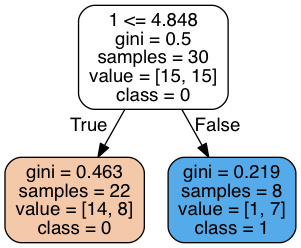

In [205]:
from IPython.display import Image

file_name = "tree.png"
Image(file_name)

# 【問題6】決定領域の可視化

決定領域を可視化してください。

In [174]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
def decision_region(X, y, model, step=0.01, title='decision region', xlabel='xlabel', ylabel='ylabel', target_names=['versicolor', 'virginica']):
    """
    2値分類を2次元の特徴量で学習したモデルの決定領域を描く。
    背景の色が学習したモデルによる推定値から描画される。
    散布図の点は訓練データまたは検証データである。

    Parameters
    ----------------
    X : ndarray, shape(n_samples, 2)
        特徴量
    y : ndarray, shape(n_samples,)
        ラベル
    model : object
        学習したモデルのインスンタスを入れる
    step : float, (default : 0.1)
        推定値を計算する間隔を設定する
    title : str
        グラフのタイトルの文章を与える
    xlabel, ylabel : str
        軸ラベルの文章を与える
    target_names= : list of str
        凡例の一覧を与える
    """
    # setting
    scatter_color = ['red', 'blue']
    contourf_color = ['pink', 'skyblue']
    n_class = 2
    # pred
    mesh_f0, mesh_f1  = np.meshgrid(np.arange(np.min(X[:,0])-0.5, np.max(X[:,0])+0.5, step), np.arange(np.min(X[:,1])-0.5, np.max(X[:,1])+0.5, step))
    mesh = np.c_[np.ravel(mesh_f0),np.ravel(mesh_f1)]
    y_pred = model.predict(mesh).reshape(mesh_f0.shape)
    # plot
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.contourf(mesh_f0, mesh_f1, y_pred, n_class-1, cmap=ListedColormap(contourf_color))
    plt.contour(mesh_f0, mesh_f1, y_pred, n_class-1, colors='y', linewidths=3, alpha=0.5)
    for i, target in enumerate(set(y)):
        plt.scatter(X[y==target][:, 0], X[y==target][:, 1], s=80, color=scatter_color[i], label=target_names[i], marker='o')
    patches = [mpatches.Patch(color=scatter_color[i], label=target_names[i]) for i in range(n_class)]
    plt.legend(handles=patches)
    plt.legend()
    plt.show()

# scikit-learnによる実装

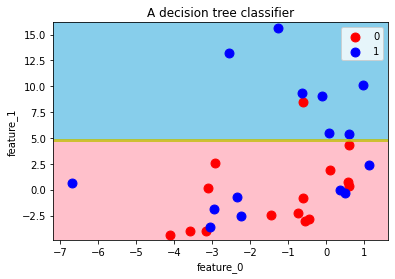

In [175]:
decision_region(X_train, y_train, clf, step=0.01, title='A decision tree classifier', xlabel='feature_0', ylabel='feature_1', target_names=['0', '1'])

# スクラッチ

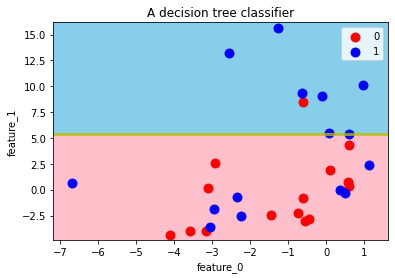

In [176]:
decision_region(X_train, y_train, clf_sc, step=0.01, title='A decision tree classifier', xlabel='feature_0', ylabel='feature_1', target_names=['0', '1'])